# Exploring the BathyBase dataset

[BathyBase](http://www.bathybase.org/) offers freely available bathymetric maps of lakes. In this notebook I plan to have a look at the available data, the geographic extent, the depth characteristics as well as the spatial resolution. I also prepare the dataset for further processing.

In [10]:
import os
import shutil
import json
import pathlib
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

standard_fig_size = (10,8)
sns.set()
%matplotlib inline

I downloaded the complete BathBase dataset to my local machine. Each leaf directory includes the bathymetric map as a tiff, png/jpeg representations, the original sources, hydrographic data (tab separated file) and a metadata `json` file. I extract the information of these json files to get a better picture about the information I care for.

In [3]:
# change to the directory where the data is stored on your machine
bathy_db_base_path = "C:/DS_projects/sdb_src/BathybaseDb/"

bathy_db_pp = pathlib.PurePath(bathy_db_base_path)

lake_infos = []
for root, dirs, files in os.walk(bathy_db_pp):
    for file in files:
        if file.endswith(".json"):
            full_file_path = os.path.join(root, file)
            with open(full_file_path) as f:
                lake_info = json.load(f)
                lake_info["source_dir"] = root
                lake_infos.append(lake_info)

lake_info_df = pd.DataFrame.from_records(lake_infos)
lake_info_gdf = gpd.GeoDataFrame(
    lake_info_df, geometry=gpd.points_from_xy(lake_info_df.Lon, lake_info_df.Lat))

lake_info_gdf

,Name,Source,Lat,Lon,Mean Depth,Max Depth,Volume,source_dir,WBIC,Observation Source,DOWLKNUM,geometry
0,Crater Lake,http://oe.oregonexplorer.info/craterlake/bathy...,42.941904,-122.106574,351.3,591.9,18615108400,C:\DS_projects\sdb_src\BathybaseDb\1-99\1,NaN,NaN,NaN,POINT (-122.10657 42.94190)
1,Summit Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,45.373955,-89.207113,3.0,7.6,3393200,C:\DS_projects\sdb_src\BathybaseDb\1-99\10,1445600.0,NaN,NaN,POINT (-89.20711 45.37395)
2,Green Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,43.809624,-88.997684,31.2,67.1,934184600,C:\DS_projects\sdb_src\BathybaseDb\1-99\11,146100.0,NaN,NaN,POINT (-88.99768 43.80962)
3,Pesobic Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,45.212764,-89.681004,1.8,3.4,1101900,C:\DS_projects\sdb_src\BathybaseDb\1-99\12,1481600.0,NaN,NaN,POINT (-89.68100 45.21276)
4,East Spring Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,43.813276,-89.302434,6.9,14.9,696900,C:\DS_projects\sdb_src\BathybaseDb\1-99\13,155300.0,NaN,NaN,POINT (-89.30243 43.81328)
...,...,...,...,...,...,...,...,...,...,...,...,...
1317,Wakefield,http://www.mngeo.state.mn.us/chouse/water_lake...,44.994614,-93.035840,4.3,8.0,344300,C:\DS_projects\sdb_src\BathybaseDb\900-999\995,NaN,GPS,62001100,POINT (-93.03584 44.99461)
1318,Phalen,http://www.mngeo.state.mn.us/chouse/water_lake...,44.987629,-93.052802,23.3,91.0,18693100,C:\DS_projects\sdb_src\BathybaseDb\900-999\996,NaN,ORIG MAP,62001300,POINT (-93.05280 44.98763)
1319,Beaver,http://www.mngeo.state.mn.us/chouse/water_lake...,44.973085,-93.004706,6.6,12.7,2194700,C:\DS_projects\sdb_src\BathybaseDb\900-999\997,NaN,GPS,62001600,POINT (-93.00471 44.97309)
1320,East Vadnais,http://www.mngeo.state.mn.us/chouse/water_lake...,45.052149,-93.088270,25.0,57.9,39625600,C:\DS_projects\sdb_src\BathybaseDb\900-999\998,NaN,ORIG MAP,62003801,POINT (-93.08827 45.05215)


I assume that the lat/long coordinates give the centroid location of each lake on the globe. Looking at the plot below we can see that all those lakes are located in the US.

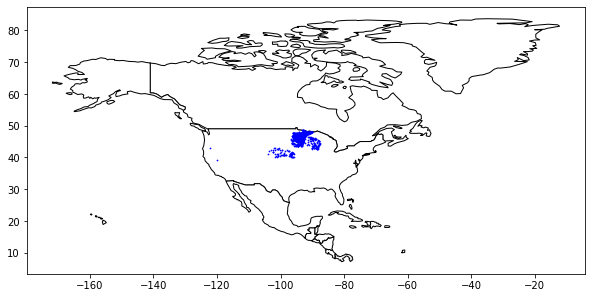

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
world[world.continent == "North America"].plot(
    color='white', edgecolor='black', ax=ax)
lake_info_gdf.plot(ax=ax, color='blue', markersize=0.5)
plt.show()

From what I can tell of the data most of the bathymetric maps appear to be originals from the respective natural resources departments. We can say a big thank you to the Minnesota Geospatial Commons program. Of course I haven't tried doing in-depth analysis with the data but they should be of good quality.

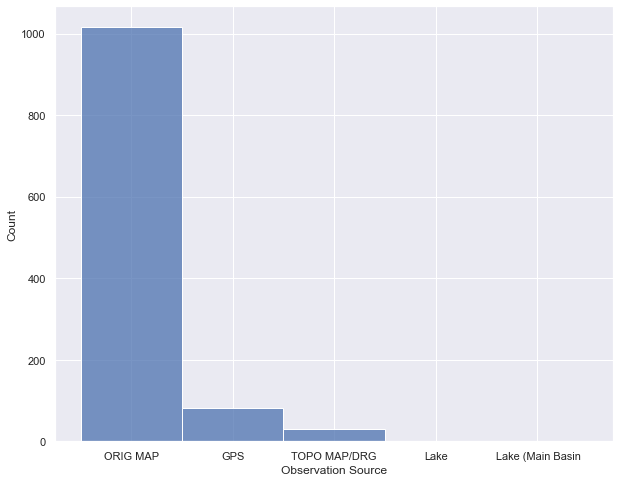

In [11]:
_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
sns.histplot(data=lake_info_gdf, x="Observation Source", ax=ax)
plt.show()

Looking at the distribution of depths I would say that most lakes have a depth profile that is well in our range (<25m in depth). Because there are only very few examples with mean depths over 50m I would throw out those outliers.

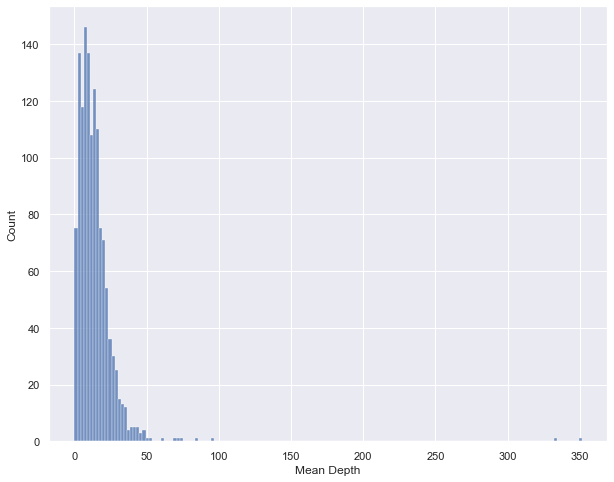

In [12]:
_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
sns.histplot(data=lake_info_gdf, x="Mean Depth", ax=ax)
plt.show()

In [13]:
(lake_info_gdf["Mean Depth"] > 50).sum()

10

The same goes for the max depth. We are only interested in depths up to 25m but I don't think that it would hurt to predict values up to 100m as most of our observations are within this range. My assumption looking at the mean depth is that there are parts in most lakes that are very deep while the rest is usually more shallow. I'd still throw out the observations with max depths higher than 100m, though, as we have very little samples for those. We could still try to get more precision, but I'd only touch them if we are really stripped for more data.

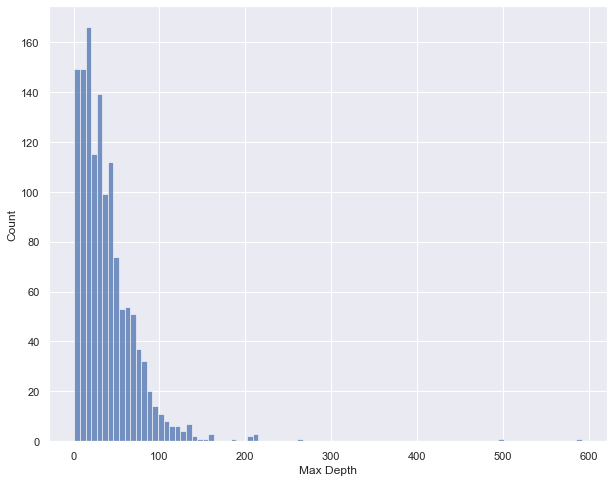

In [14]:
_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
sns.histplot(data=lake_info_gdf, x="Max Depth", ax=ax)
plt.show()

In [15]:
(lake_info_gdf["Max Depth"] > 100).sum()

53

In [16]:
lakes_aoi = lake_info_gdf.loc[(lake_info_gdf["Max Depth"] < 100) & (lake_info_gdf["Mean Depth"] < 50)]
lakes_aoi

,Name,Source,Lat,Lon,Mean Depth,Max Depth,Volume,source_dir,WBIC,Observation Source,DOWLKNUM,geometry
1,Summit Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,45.373955,-89.207113,3.0,7.6,3393200,C:\DS_projects\sdb_src\BathybaseDb\1-99\10,1445600.0,NaN,NaN,POINT (-89.20711 45.37395)
2,Green Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,43.809624,-88.997684,31.2,67.1,934184600,C:\DS_projects\sdb_src\BathybaseDb\1-99\11,146100.0,NaN,NaN,POINT (-88.99768 43.80962)
3,Pesobic Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,45.212764,-89.681004,1.8,3.4,1101900,C:\DS_projects\sdb_src\BathybaseDb\1-99\12,1481600.0,NaN,NaN,POINT (-89.68100 45.21276)
4,East Spring Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,43.813276,-89.302434,6.9,14.9,696900,C:\DS_projects\sdb_src\BathybaseDb\1-99\13,155300.0,NaN,NaN,POINT (-89.30243 43.81328)
5,West Spring Lake,http://dnr.wi.gov/lakes/Documents/LakeMaps.aspx,43.815044,-89.305954,4.4,7.9,124800,C:\DS_projects\sdb_src\BathybaseDb\1-99\14,155400.0,NaN,NaN,POINT (-89.30595 43.81504)
...,...,...,...,...,...,...,...,...,...,...,...,...
1317,Wakefield,http://www.mngeo.state.mn.us/chouse/water_lake...,44.994614,-93.035840,4.3,8.0,344300,C:\DS_projects\sdb_src\BathybaseDb\900-999\995,NaN,GPS,62001100,POINT (-93.03584 44.99461)
1318,Phalen,http://www.mngeo.state.mn.us/chouse/water_lake...,44.987629,-93.052802,23.3,91.0,18693100,C:\DS_projects\sdb_src\BathybaseDb\900-999\996,NaN,ORIG MAP,62001300,POINT (-93.05280 44.98763)
1319,Beaver,http://www.mngeo.state.mn.us/chouse/water_lake...,44.973085,-93.004706,6.6,12.7,2194700,C:\DS_projects\sdb_src\BathybaseDb\900-999\997,NaN,GPS,62001600,POINT (-93.00471 44.97309)
1320,East Vadnais,http://www.mngeo.state.mn.us/chouse/water_lake...,45.052149,-93.088270,25.0,57.9,39625600,C:\DS_projects\sdb_src\BathybaseDb\900-999\998,NaN,ORIG MAP,62003801,POINT (-93.08827 45.05215)


The cells below are used to get all the `tiff` files of the lakes we're interest in and move them to a directory which is checked into dvc. I also write the `geodataframe` holding all the metadata so we don't have to reconstruct anything from the base dataset if we want to do another analysis.

In [17]:
target_path = "../data/bathybase"
data_target_path = os.path.join(target_path, "bathy_tiffs")
if not os.path.exists(data_target_path):
    os.makedirs(data_target_path, exist_ok=True)

names_and_sources = lakes_aoi[["Name", "source_dir"]].to_records().tolist()
from_to_paths = [
    (
        idx,
        os.path.join(dir, "bathy.tiff"),
        os.path.join(data_target_path, f"{name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_').replace('.', '_').replace('-', '_').replace('#', 'nr')}.tiff")
    ) for (idx, name, dir) in names_and_sources
]

for (_, from_path, to_path) in from_to_paths:
    shutil.copy(from_path, to_path)

In [18]:
idx, values = zip(*[(idx, os.path.relpath(path).replace("\\", "/")) for (idx, _, path) in from_to_paths])
target_series = pd.Series(values, idx)

output_df = lakes_aoi.assign(file_location=target_series).drop(columns=["WBIC", "DOWLKNUM ", "source_dir"])
output_df.to_csv(os.path.join(target_path, "bathy_lakes_aoi.csv"), index=False)

## Inspection of Rasters

I still don't know much about the spatial resolution of the rasters. I generally don't want to keep anything below 10x10m spatial resolution because that is the finest one we get from Landsat-2 (bands 2, 3, 4 and 8). In this part I just want to try and find out if the dataset is uniform and if we can keep the data.

In [20]:
import rioxarray as rxr

I first look at one sample to see what I can extract from those geoTIFFs. In this case I use `rioxarry` which is an additional module for `xarray` which uses `rasterio` so as far as I understand you get `xarray` objects while still having all the meta information you would get from `rasterio`.

In [21]:
sample_tiff = rxr.open_rasterio(output_df["file_location"].iloc[0])
sample_tiff

<xarray.DataArray (band: 1, y: 384, x: 335)>
[128640 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -2.494e+04 -2.494e+04 ... -2.328e+04 -2.327e+04
  * y            (y) float64 2.085e+06 2.085e+06 ... 2.083e+06 2.083e+06
    spatial_ref  int32 0
Attributes:
    COLOR_TABLE_RULES_COUNT:  5
    COLOR_TABLE_RULE_RGB_0:   9.144000e-001 2.560320e+000 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   2.560320e+000 4.206240e+000 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   4.206240e+000 5.852160e+000 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   5.852160e+000 7.498080e+000 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   7.498080e+000 9.144000e+000 255 0 255 255 0 0
    _FillValue:               nan
    scale_factor:             1.0
    add_offset:               0.0

At least for this sample the unit of measurement should be `metre`. I checked a couple of samples in QGIS before and they appear to be consistent with that. As far as I can tell there appears to be more variation in the used CRS. At least it appears to be present everywhere but we need to remember that we'll most likely have to reproject later.

In [22]:
print(sample_tiff.rio.crs.linear_units)
print(sample_tiff.rio.crs)

metre
ESRI:102039


I really like how easy it is to plot `xarray` objects. No deeper analytical comment. Just me being happy about a library.

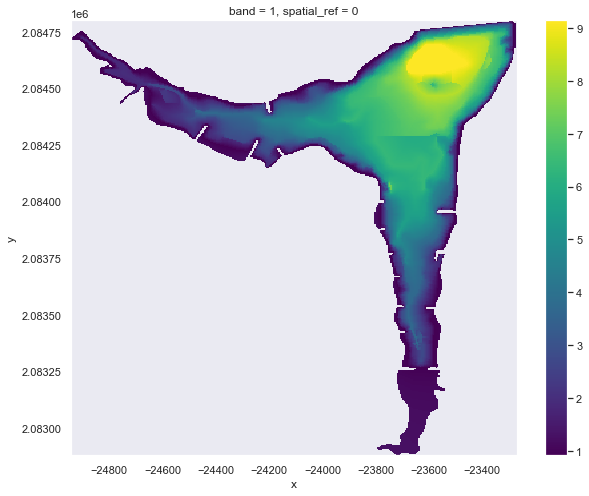

In [23]:
_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
sample_tiff.plot(ax=ax)
plt.show()

Same thing for histograms. I just like it when common tasks can be done without a lot of extra work.

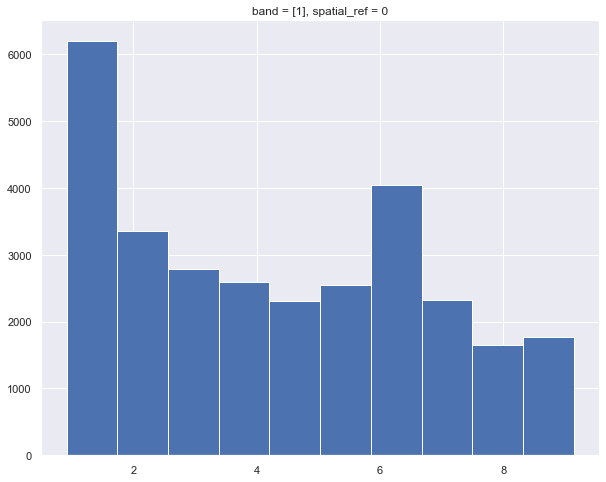

In [24]:
_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
sample_tiff.plot.hist(ax=ax)
plt.show()

The resolution appears to be a part of the transform attribute, at least that's what the [documentation](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.rioxarray.XRasterBase.resolution) says. We could also try to recalculate it from the other present information but I don't see a reason to do that. I'm not entirely sure how trustworthy this info is so I grabbed a couple of examples and measured the pixel widths "by hand" in QGIS. The values I measured and the values I can extract here are the same.

In [25]:
sample_tiff.rio.resolution()

(5.0, -5.0)

As all the different files are pretty consistent I didn't expect anything else but I still wanted to make sure that we always have the same resolution. They appear to always have a 5x5m spatial resolution. There are little fluctuation but I assume that this has to be a projection issue that shouldn't bite use too much.

In [26]:
resolutions = []
for tiff in output_df["file_location"].values.tolist():
    with rxr.open_rasterio(tiff) as r:
        resolutions.append(r.rio.resolution())

xres, yres = zip(*resolutions)
resolutions = pd.DataFrame({"xres":xres, "yres":yres})

resolutions.describe()

,xres,yres
count,1264.000000,1264.000000
mean,5.000049,-5.000304
std,0.010195,0.012066
min,4.945066,-5.076352
25%,4.996986,-5.003254
50%,5.000000,-5.000000
75%,5.003346,-4.996708
max,5.062621,-4.919246


In [28]:
sample_tiff

<xarray.DataArray (band: 1, y: 384, x: 335)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -2.494e+04 -2.494e+04 ... -2.328e+04 -2.327e+04
  * y            (y) float64 2.085e+06 2.085e+06 ... 2.083e+06 2.083e+06
    spatial_ref  int32 0
Attributes:
    COLOR_TABLE_RULES_COUNT:  5
    COLOR_TABLE_RULE_RGB_0:   9.144000e-001 2.560320e+000 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   2.560320e+000 4.206240e+000 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   4.206240e+000 5.852160e+000 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   5.852160e+000 7.498080e+000 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   7.498080e+000 9.144000e+000 255 0 255 255 0 0
    _FillValue:               nan
    scale_factor:             1.0
    add_offset:               0.0